In [1]:
import os
os.environ['LIWC_PATH'] = "data/LIWC.json"
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMBA_NUM_THREADS'] = '8'
from os.path import join, dirname
import sys
sys.path.append('../')

from functools import partial

import numpy as np
from scipy import sparse as sp
import numba as nb
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import roc_auc_score

from lyricpsych.utils import (load_csr_data,
                              split_recsys_data,
                              slice_row_sparse,
                              prepare_feature,
                              get_all_comb)
from lyricpsych.tasks.fm import *
from lyricpsych.tasks.als_feat import *
from lyricpsych.tasks.recsys import UserKNN, build_user_profile
from lyricpsych.utils import split_recsys_data, slice_row_sparse
from lyricpsych.metrics import ndcg

from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
from tqdm import tqdm


def load_data(recsys_data_fn, text_feat_data_fn):
    """"""
    print('Loading data...')
    X, users, items = load_csr_data(recsys_data_fn)
    item_hash_rec_data = {tid:j for j, tid in enumerate(items)}
    feature, track2id, pca, sclr, feature_sets = prepare_feature(text_feat_data_fn)
    
    mutual_tid = [tid for tid in items if tid in track2id]
    ix = [track2id[i] for i in mutual_tid]
    Y = np.concatenate(
        [feat[ix] for k, feat in feature.items()],
        axis=1
    )
    
    sclr = StandardScaler()
    # sclr = QuantileTransformer()
    Y = sclr.fit_transform(Y)
    mut_tid_set = set(mutual_tid)
    targets = [item_hash_rec_data[tid] for tid in mutual_tid]
    X2 = X[:, targets]
    return X2, Y, users, mutual_tid

In [2]:
def evaluate_alsfeat_tagger_outmat(alsfeat, Xvlsd, Xvlvl, Yvl,
                                   n_tests=3000, topk=10, mode='out_matrix_feat',
                                   metric='nDCG', average='samples'):
    """ Evaluating trained ALSFeat model
    
    alsfeat (ALSFeat): trained ALSFeat model
    Xtrtr (scipy.sparse.csr_matrix): training (full edge) matrix
    Xvlsd (scipy.sparse.csr_matrix): validation seed item matrix
    Xvlvl (scipy.sparse.csr_matrix): validation test item matrix
    n_tests (int): number of testing entities (user/song)
    topk (int): evaluation cutoff
    mode (string): evaluation mode
        out_matrix_feat => cold-start scenario with only feature (no seed)
        out_matrix_rand => cold-start scenario with random vector (only seed)
        out_matrix_zero => cold-start scenario with zero vector (only seed)
        out_matrix_all => cold-start scenario with seeds & feature
    metric (string): metric indicator {'nDCG', 'ROCAUC'}
                    *'ROCAUC' is only compatible with 'out_matrix_feat'
    average (string): metric average dimension (for ROCAUC only) {'macro', 'samples'}
    """
    assert mode in {
        'out_matrix_feat', 'out_matrix_rand',
        'out_matrix_zero', 'out_matrix_all'
    }
    scores = []
    labels = []

    # pre-compute UU
    W = alsfeat.embeddings_['feat']
    V = alsfeat.embeddings_['item']
    U = alsfeat.embeddings_['user']
    UU = U.T @ U

    if mode == 'out_matrix_feat':
        Xvlvl = (Xvlvl + Xvlsd).copy()
    for u in np.random.choice(Xvlvl.shape[0], n_tests, False):
        true = Xvlvl[u].indices
        if len(true) == 0:
            continue
        
        if mode != 'out_matrix_feat':
            seeds = Xvlsd[u].copy()
            seeds_ind = seeds.indices
            seeds_val = seeds.data

        # infer new item factor using partial ALS
        if mode == 'out_matrix_rand':
            x = np.random.randn(X.shape[1]).astype(mf.dtype)
        elif mode == 'out_matrix_zero':
            x = np.zeros(X.shape[1], dtype=mf.dtype)
        else:
            x = Yvl[u]
    
        if mode == 'out_matrix_feat':
            v = x @ W
        else:
            v = partial_ALS_feat(
                seeds_val, seeds_ind,
                U, UU, V, x, W, alsfeat.lmbda, alsfeat.l2
            )
        s = v @ U.T
        
        if mode != 'out_matrix_feat':
            s[seeds_ind] = -np.inf
        idx = np.argpartition(-s, kth=topk)[:topk]
        pred = idx[np.argsort(-s[idx])]
        
        if mode == 'out_matrix_feat' and metric == 'ROCAUC':
            scores.append(s)
            labels.append(Xvlvl[u].toarray())
        else:
            scores.append(ndcg(true, pred, topk))

    if mode == 'out_matrix_feat' and metric == 'ROCAUC':
        scores = np.vstack(scores)  # (n_valid, n_tags)
        labels = np.vstack(labels)  # (n_valid, n_tags)
        return roc_auc_score(labels, scores, average=average)
    else:            
        return np.mean(scores)

# Possibilities

1. partial learning of item factor for given seed tags and the feature using ALS
2. hybrid model using NN as the feature encoder and the ALS for other parts
    - 1 iteration:: ALS(user) -> ALS(item) -> ALS(feat>item)
    - issues such as learning time / more parameters
    - potentially better model will be obtained anyway
3. performance?

In [15]:
# HERE WE LOAD DATA
root = '/home/jaykim/Documents/workbench/lyricpsych/'
recsys_data_fn = join(root, 'data/recsys_data.h5')
text_feat_data_fn = join(root, 'data/text_feat_test.h5')
X, Y, users, items = load_data(recsys_data_fn, text_feat_data_fn)
Y = Y[:, 240+72:]
# X = sp.load_npz('../data/top50_msd/labels.npz')
# Y = np.load('../data/top50_msd/mfcc.npy')

print('Splitting the data...')
Xtr, Xvl, Xts = split_recsys_data(X, train_ratio=0.8, valid_ratio=0.1)

Loading data...
Splitting the data...


In [30]:
# split itemwise
rnd_idx = np.random.permutation(X.shape[1])  # for user-item mat
# rnd_idx = np.random.permutation(X.shape[0])
train_bound = int(len(rnd_idx) * 0.6)
valid_bound = train_bound + int(len(rnd_idx) * 0.2)

Ytr = Y[rnd_idx[:train_bound]]
Yvl = Y[rnd_idx[train_bound:valid_bound]]
Yts = Y[rnd_idx[valid_bound:]]

Xtrtr = X[:, rnd_idx[:train_bound]]
Xvlvl = X[:, rnd_idx[train_bound:valid_bound]]
Xtsts = X[:, rnd_idx[valid_bound:]]
# Xtrtr = X[rnd_idx[:train_bound]].T.tocsr()
# Xvlsd = Xtr[rnd_idx[train_bound:valid_bound]].T.tocsr()
# Xvlvl = Xvl[rnd_idx[train_bound:valid_bound]].T.tocsr()
# Xtssd = Xtr[rnd_idx[valid_bound:]].T.tocsr()
# Xtsts = Xts[rnd_idx[valid_bound:]].T.tocsr()
# Xtr = Xtr.T.tocsr()
# Xvl = Xvl.T.tocsr()
# Xts = Xts.T.tocsr()

In [17]:
mf = ALSFeat(32, lmbda=1, l2=1e-4, alpha=20, n_iters=15)
mf.fit(Xtr, Y, Xvl, verbose=True)

[vacc=0.1250]: 100%|████████████████████████████| 15/15 [03:16<00:00, 13.11s/it]


In [18]:
scores = []
n_tests = 3000
topk = 100
for u in np.random.choice(Xvl.shape[0], n_tests, False):
    true = Xvl[u].indices
    if len(true) == 0:
        continue
    train = Xtr[u].indices
    
    s = mf.embeddings_['user'][u] @ mf.embeddings_['item'].T
    s[train] = -np.inf
    idx = np.argpartition(-s, kth=topk)[:topk]
    pred = idx[np.argsort(-s[idx])]
    scores.append(ndcg(true, pred, topk))
np.mean(scores)

0.11612763606149444

# OUT-MATRIX performance on RecSys

In [176]:
k = 32
mf = ALSFeat(k, lmbda=1e+4, l2=1e-5, alpha=0, n_iters=30)
mf.fit(Xtrtr, Ytr, None, verbose=True)

[vacc=0.0000]: 100%|████████████████████████████| 30/30 [03:13<00:00,  6.46s/it]


In [49]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor((256, 256))
mlp.fit(Ytr, mf.embeddings_['item'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(256, 256), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [181]:
scores = []
n_tests = 2000
topk = 100
X_test = sp.hstack([Xtrtr, Xvlvl]).tocsr()
U = mf.embeddings_['user']
V = mf.embeddings_['item']
W = mf.embeddings_['feat']
UU = U.T @ U
# Vvl = np.vstack([
#     partial_ALS_feat(
#     np.array([],dtype=np.float32),
#     np.array([],dtype=np.int32),
#     U, UU, V, x, W, mf.lmbda, mf.l2)
#     for x in Yvl
# ])
Vvl = Yvl @ W
# # Vvl = mlp.predict(Yvl)
Vfull = np.concatenate([V, Vvl], axis=0)

for u in np.random.choice(X_test.shape[0], n_tests, False):
    pos = X_test[u].indices
    train, true = pos[pos < train_bound], pos[pos >= train_bound]
    if len(true) == 0:
        continue
    s = mf.embeddings_['user'][u] @ Vfull.T
    s[train] = -np.inf
    idx = np.argpartition(-s, kth=topk)[:topk]
    pred = idx[np.argsort(-s[idx])]
    scores.append(ndcg(true, pred, topk))

np.mean(scores)

0.000523483775869176

In [182]:
b = Yvl[10] @ W * mf.lmbda
A = UU + (mf.lmbda + mf.l2) * np.eye(UU.shape[0])
np.linalg.solve(A, b)

array([ 1.25055318e-02, -2.81481798e-03,  1.09087905e-02,  6.22586218e-03,
        1.24151937e-03,  4.47419291e-03, -3.87975009e-03, -4.17048432e-03,
       -4.60057776e-03, -9.74929149e-03,  6.79975583e-03, -3.06751810e-03,
        1.74731767e-02,  1.71273293e-03, -4.96603202e-03,  1.18892735e-02,
       -5.99257541e-03, -8.65888485e-03, -8.45039778e-04, -9.26103903e-04,
        2.08860437e-03,  8.04308011e-03, -1.04174487e-02,  3.98017720e-03,
       -8.94859253e-03, -1.44010433e-02,  5.54946446e-03,  1.59189889e-02,
        4.63181607e-03, -9.44005709e-04,  4.66570813e-04, -4.69100208e-05])

In [183]:
V[10]

array([-0.00180767,  0.00345553, -0.0006292 ,  0.00807675, -0.0001517 ,
       -0.00094704,  0.00234166, -0.00949839,  0.00154013,  0.00278905,
       -0.01354419, -0.00687219, -0.00985354, -0.00332944, -0.00479536,
        0.00190486,  0.01433659, -0.01059727, -0.0099578 , -0.00589308,
        0.00389351, -0.01045518,  0.01446246, -0.00413164,  0.00465644,
        0.00501668, -0.00818767,  0.00137751, -0.0014549 ,  0.00271397,
        0.00895323, -0.01220424], dtype=float32)

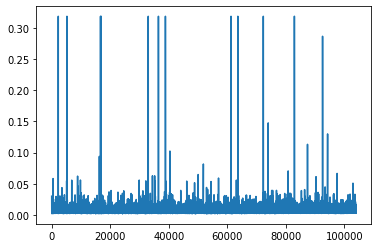

In [184]:
plt.plot(abs(Vfull).mean(1))

In [46]:
U = mf.embeddings_['user']
V = mf.embeddings_['item']
W = mf.embeddings_['feat']
# Y_ = Y[:, 240:]
# L = ((V - Y_ @ W)**2).sum()
# print(L)

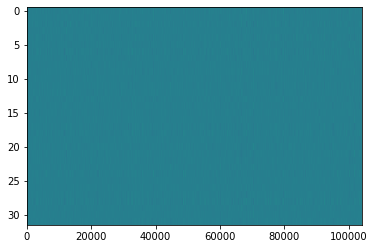

In [172]:
plt.imshow(Vfull.T, aspect='auto')

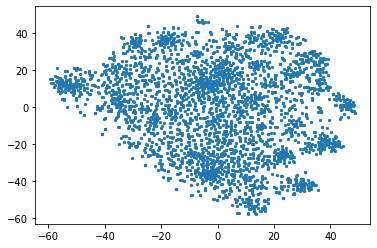

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
z2 = tsne.fit_transform(U[np.random.choice(U.shape[0], 3000, False)])
# z2 = tsne.fit_transform(U)
plt.scatter(z2[:, 0], z2[:, 1], s=5)

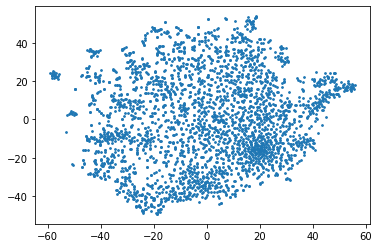

In [14]:
z2 = tsne.fit_transform(V[np.random.choice(V.shape[0], 3000, False)])
plt.scatter(z2[:, 0], z2[:, 1], s=3)

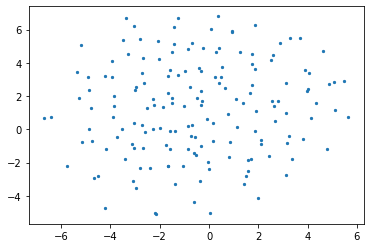

In [13]:
z2 = tsne.fit_transform(W)
plt.scatter(z2[:, 0], z2[:, 1], s=5)